# Calculation for fixed point in model between EKE and APE

probably shouldn't be neglecting the free surface as that played a huge role in the baroclinic energy conversion calculation -- ED: 50%  difference is small
research relevance - time scale of the wind effect moving down to the lower layers is important in Dundas et al
Periodicity relates to the link between each of the layers, rather than the bottom drag.

Bottom drag links to APE but not EKE (increased drag reduces amplitude of APE oscillation but not overall EKE? --> higher conversion of APE to EKE? or more barotropic? -- same result as Marshall (2017) that eke doesn't increase with bottom drag)
Wind links to EKE and period of oscillation but not APE (how does wind give more EKE without changing APE? more barotropic? less wind gives more baroclinic?)

QN: from a forces perspective, why is the system always oscillatory?



\begin{equation} \frac{dE}{dt} = \mathcal X E  \end{equation}
\begin{equation}  \rightarrow E = e^{\pm i \omega t} \text{    where   } \omega = \sqrt{ab/2} \end{equation}

In [1]:
import numpy as np
from matplotlib import rc
#rc('text', usetex=True) #60 if making small size, 45 if full wdith
rc('xtick', labelsize=45) #20 
rc('ytick', labelsize=45) #20
rc('axes', titlesize=45)    # fontsize of the axes title
rc('axes', labelsize=45) #24  
rc('font', **{'size':45})
import matplotlib.pyplot as plt


In [2]:
import xarray as xr
import netCDF4 as nc

In [3]:
# Prescribe parameters of low-order model to replicate the period of oscillation in simulations
H =  3000 #ASC[m]  ### ACC rho = 1026.89 drho = 1.2 H  = 2000 
#ACC values -- give freq of 420days but ACC so dynamics will be differnt!
drho = 0.1 #original--> before used 0.5 for diff relative to AABW layer
Hrho = 1000 ## combined height of top two layers to use for buoyancy frequency calculation

drho_dz = -drho/(Hrho/2)
f = -1e-4
g = 9.81
rho0 = 1027.8 #[kg/m^3
tau = 0.1/2
gp = drho/rho0 *g
print(gp)
#htop = 200 #[m] height of top layer thickness

Nsquared = - g/rho0 * drho_dz

0.0009544658493870405


In [6]:
Ly = 200e3 #np.sqrt(Nsquared) * H /f #2e4 #7e3 #rossby deformation radius
print(Ly)

a = (2* abs(f) *gp /(f*np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))
a = (2 *gp /(np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3)) 

a

200000.0


1.2734153133564038e-11

In [8]:
b = (2*tau*gp*Ly/f) *np.sqrt(6/(rho0*gp*Ly**3))
b = alpha * (2*tau*gp*Ly/abs(f)) *np.sqrt(6/(rho0*gp*Ly**3))

b

0.003219707006776219

In [9]:
omega = np.sqrt(a*b/2)
period = 2*np.pi/omega
period/(60*60*24) # period in days

507.9113446495789

In [10]:
"{:e}".format((5e-7/a)**2)
# equilibrium APE
# the equilibrium value of E is 100x greater, and we are assuming small perturbations about this equilibrium value.
# therefore, we add another factor of m (magnitude) to scale the APE in our non-linear equations, so that the non-dimensionalised system is 
# solved on orders $O ~ (0.1,10)

'1.541700e+09'

In [11]:
"{:e}".format(b/a)
#equilibrium E

'2.528403e+08'

In [12]:
from scipy.integrate import odeint, solve_ivp

We need to non-dimensionalise the energy equations of the low-order models so that we can solve them fully, starting from initial conditions near their equilibrium value.
\begin{equation}
    d\epsilon/d\tau =  \sqrt{p} \epsilon - \sqrt{m}\epsilon
\end{equation}

\begin{equation}
    dp/d\tau =  \alpha ab/\lambda^{2}  \sqrt{p}  - \alpha ab/\lambda^{2}  \epsilon \sqrt{p} 
\end{equation}

where $E = \epsilon (b/ \alpha a)$ and $APE = (\lambda/ \alpha a)^{2} p m$, and $t = \tau\sqrt(m)/\lambda$

In [13]:
# this is the tolerance of the solver
# despite mathematically both e and p are >0, the solver can make atol mistake and thus give p = -atol...
# so below, in the RHS function introduce a "hack" to avoid such case
# I checked that solution is converged and does not depend on the value of atol

In [181]:
## for eady/slope 
alpha = 0.001# 0.61 eady

In [182]:
atol = 1e-11
E0 = [1.05,1.05] #[E,APE]
cdrag = 5e-7 # 4e-7 has correct drag
M = 1# for p and dt
Me = 1 # for \epsilon
scale = 1e-3 ## idk  what this does


t = np.linspace(0,20*365*24*60*60*cdrag,120000) #*365*24*60*60*cdrag/int(np.sqrt(M))
p = (a, b, cdrag)
def energies(state,t, a,b,cdrag):
    E, APE =  state 
    dE =   np.sqrt(max(atol, APE)) * E - E  * np.sqrt(M)
    dAPE = b * np.sqrt(max(atol, APE))*alpha*a /cdrag**2 -   Me*alpha* a * b * E *np.sqrt(max(atol, APE))  /cdrag**2 + (scale * t)**2
    return [dE, dAPE]

In [183]:
"{:e}".format(np.mean((cdrag/a)**2)) #equilibrium APE

'1.541700e+09'

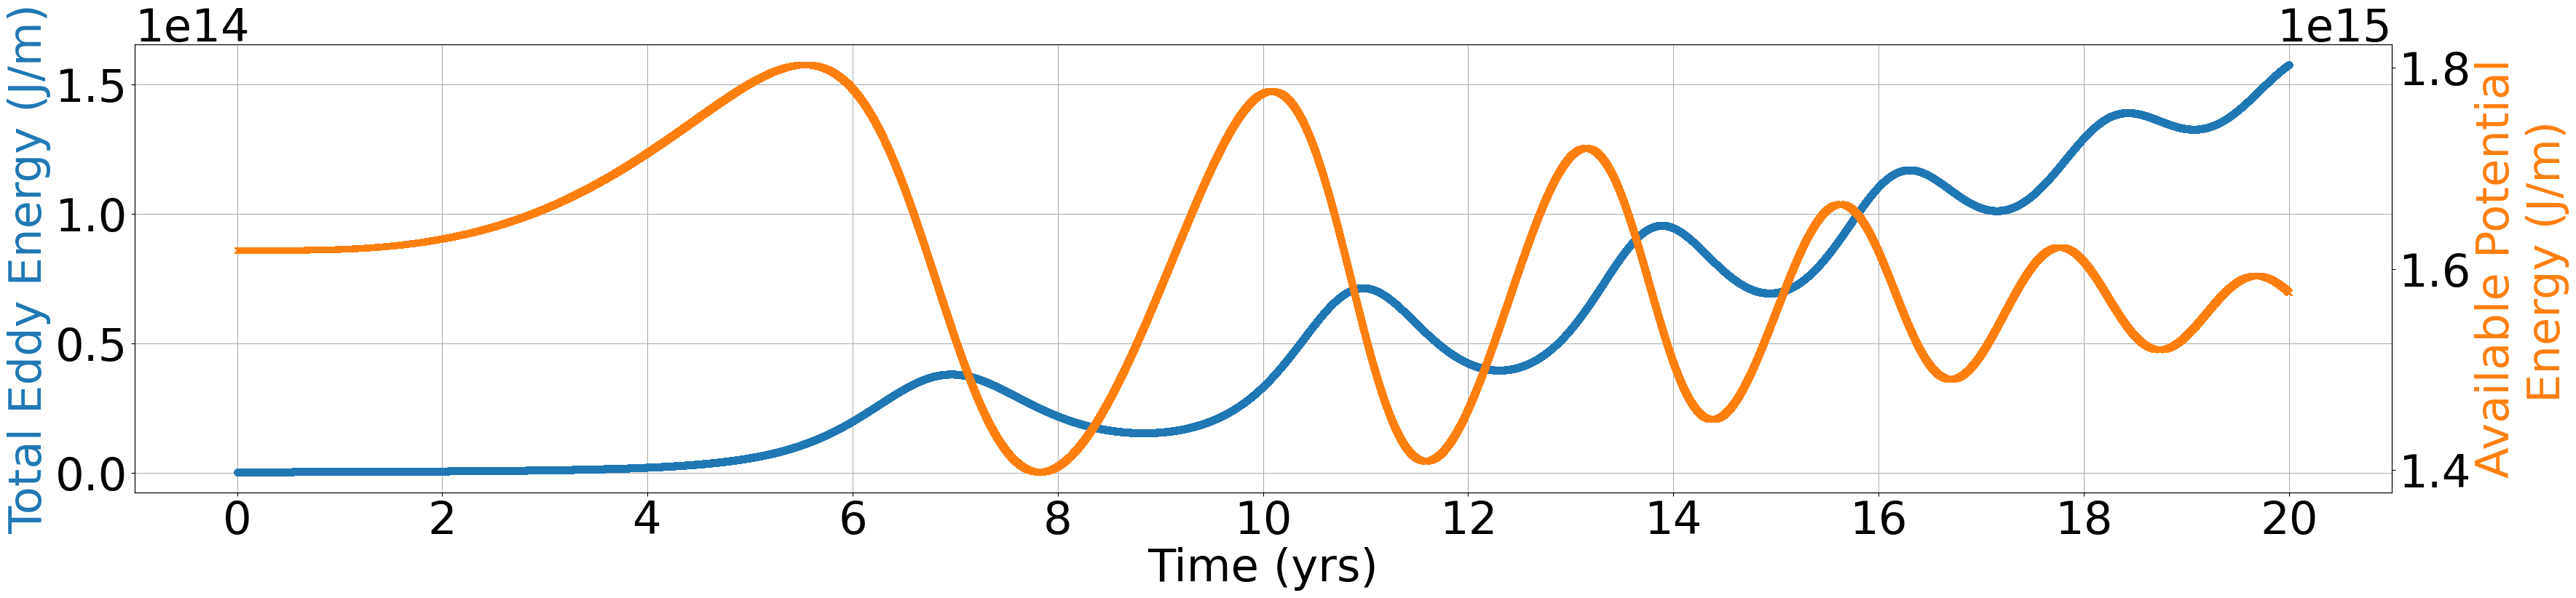

In [184]:
result_odeint = odeint(energies, E0, t, p ,atol=atol, rtol=100*atol)
plt.figure(figsize = (40,8))
ax1 = plt.subplot()

ax1.plot(t/cdrag/(365*60*60*24), result_odeint[:,0]*Me*b/(alpha*a), marker = 'o', label = 'E',color = 'C0')
#ax1.set_ylim([0,3.5e9])
ax1.set_ylabel('Total Eddy Energy (J/m)', color = 'C0')
#ax1.set_yticks(np.arange(0.3e9,.55e9,1e8))

ax2 = ax1.twinx()
ax2.plot(t/cdrag/(365*60*60*24), result_odeint[:,1]*(cdrag/(alpha*a))**2 *M , marker = 'x', label = 'APE', color = 'C1')
ax2.set_ylabel('Available Potential\n Energy (J/m)', color = 'C1')
#ax2.set_ylim([0,3.5e9])
#ax2.set_yticks(np.arange(1.4e9,1.8e9,1e8))
plt.xticks(np.arange(0,22,2))
ax1.set_xlabel('Time (yrs)')

ax1.grid(which = 'both')
## I still don't fully understand why t does not need to be dimensionalised

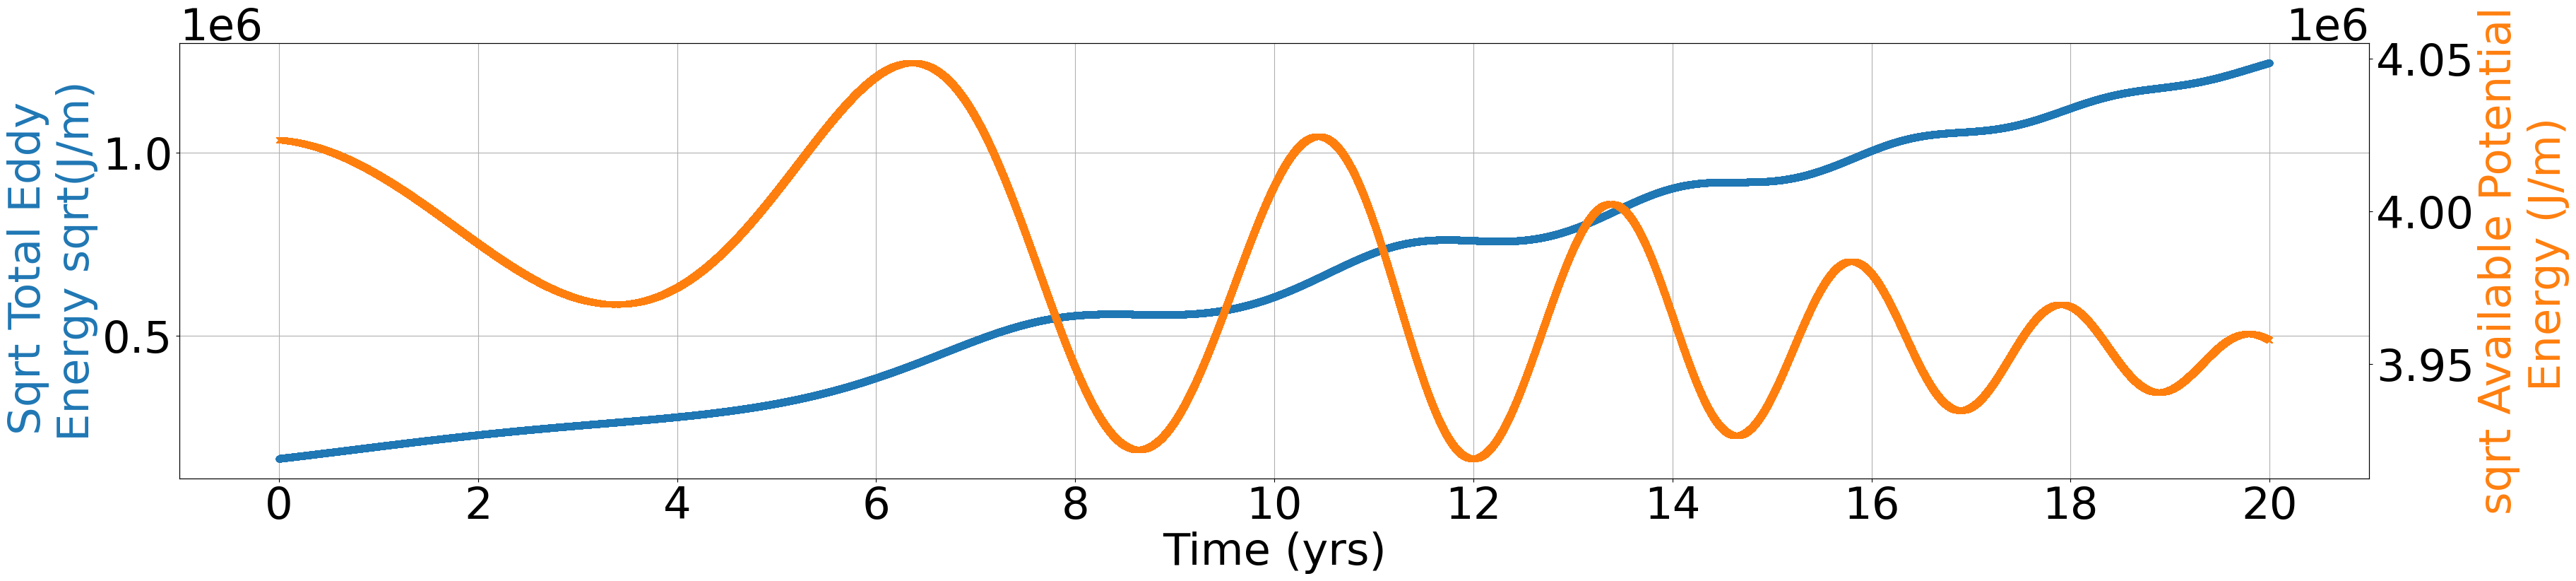

In [174]:
result_odeint = odeint(energies, E0, t, p ,atol=atol, rtol=100*atol)
plt.figure(figsize = (40,8))
ax1 = plt.subplot()

ax1.plot(t/cdrag/(365*60*60*24), np.sqrt(result_odeint[:,0]*Me*b/(alpha*a)), marker = 'o', label = 'E',color = 'C0')
#ax1.set_ylim([0,3.5e9])
ax1.set_ylabel('Sqrt Total Eddy \nEnergy sqrt(J/m)', color = 'C0')
#ax1.set_yticks(np.arange(0.3e9,.55e9,1e8))

ax2 = ax1.twinx()
ax2.plot(t/cdrag/(365*60*60*24),  np.sqrt(result_odeint[:,1]*(cdrag/(alpha*a))**2 *M ), marker = 'x', label = 'APE', color = 'C1')
ax2.set_ylabel('sqrt Available Potential\n Energy (J/m)', color = 'C1')
#ax2.set_ylim([0,3.5e9])
#ax2.set_yticks(np.arange(1.4e9,1.8e9,1e8))
plt.xticks(np.arange(0,22,2))
ax1.set_xlabel('Time (yrs)')

ax1.grid(which = 'both')
## I still don't fully understand why t does not need to be dimensionalised



In [118]:
atol = 1e-11
E0 = [1.005,2] #[E,APE]
cdrag = 5e-7 # 4e-7 has correct drag
M = 1# for p and dt
Me = 1 # for \epsilon
scale = 5e-3 ## idk  what this does


t = np.linspace(0,20*365*24*60*60*cdrag,120000) #*365*24*60*60*cdrag/int(np.sqrt(M))
p = (a, b, cdrag)
def energies(state,t, a,b,cdrag):
    E, APE =  state 
    dE =   np.sqrt(max(atol, APE) * (t/20*365*24*60*60*cdrag)**3) * E - E  * np.sqrt(M)
    dAPE = b * np.sqrt(max(atol, APE)* (t/20*365*24*60*60*cdrag)**3)*alpha*a /cdrag**2 -   Me*alpha* a * b * E *np.sqrt(max(atol, APE)*( t/20*365*24*60*60*cdrag)**3)  /cdrag**2 #+ scale * t
    return [dE, dAPE]

In [119]:
"{:e}".format(np.mean((cdrag/a)**2)) #equilibrium APE

'1.541700e+09'

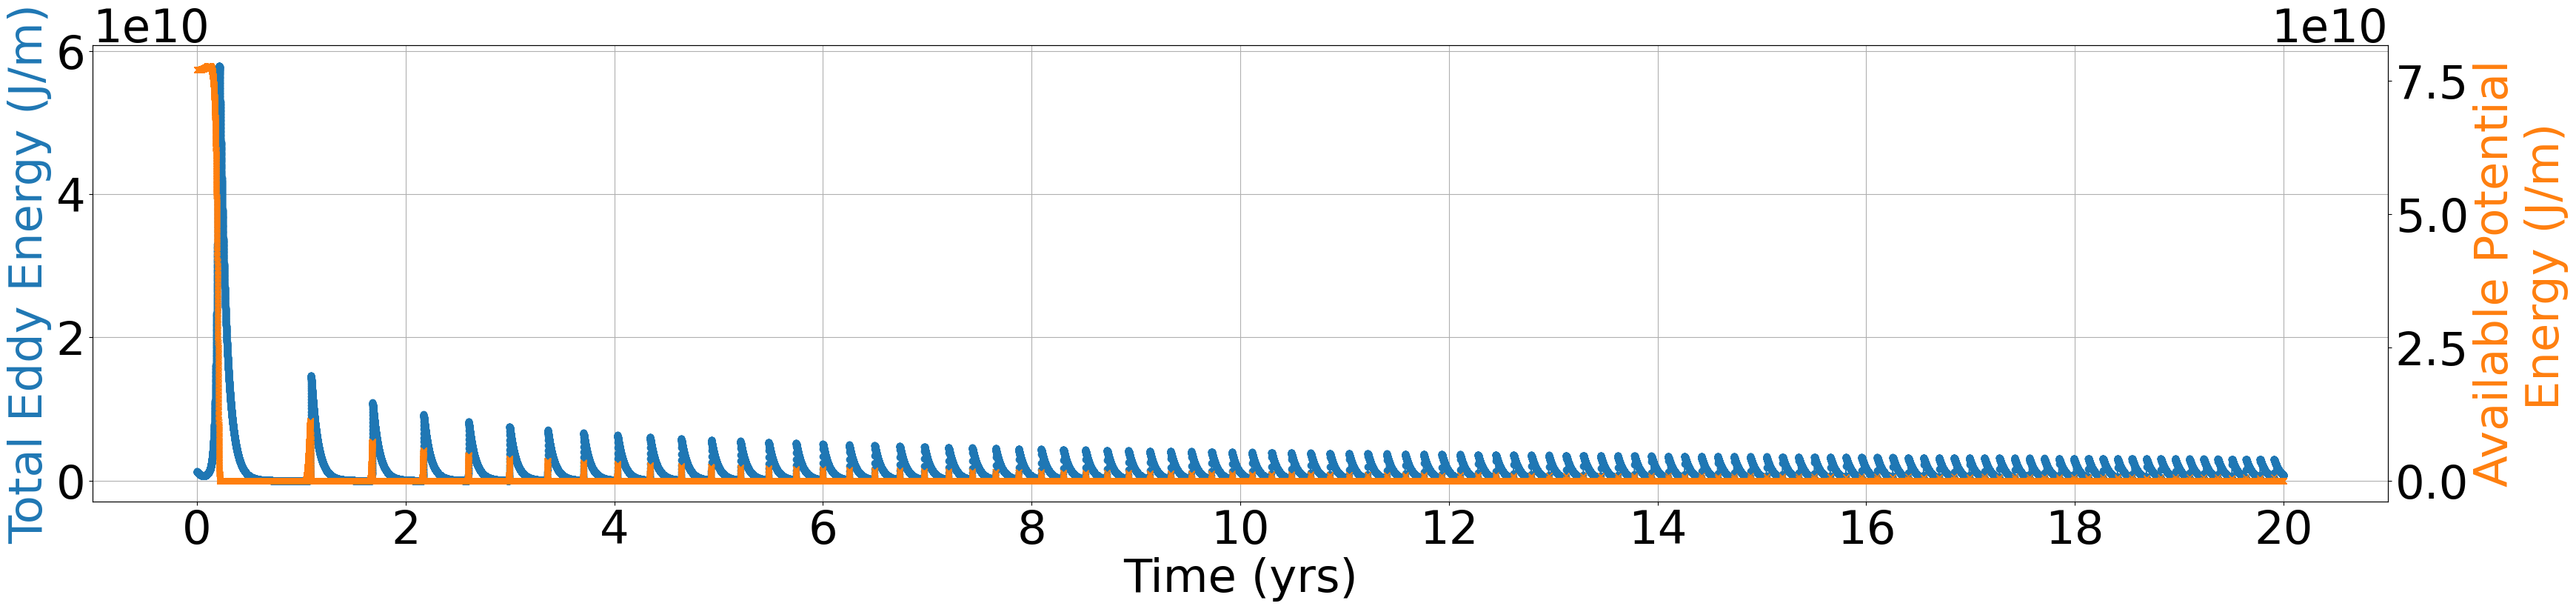

In [120]:
result_odeint = odeint(energies, E0, t, p ,atol=atol, rtol=100*atol)
plt.figure(figsize = (40,8))
ax1 = plt.subplot()

ax1.plot(t/cdrag/(365*60*60*24), result_odeint[:,0]*Me*b/(alpha*a), marker = 'o', label = 'E',color = 'C0')
#ax1.set_ylim([0,3.5e9])
ax1.set_ylabel('Total Eddy Energy (J/m)', color = 'C0')
#ax1.set_yticks(np.arange(0.3e9,.55e9,1e8))

ax2 = ax1.twinx()
ax2.plot(t/cdrag/(365*60*60*24), result_odeint[:,1]*(cdrag/(alpha*a))**2 *M , marker = 'x', label = 'APE', color = 'C1')
ax2.set_ylabel('Available Potential\n Energy (J/m)', color = 'C1')
#ax2.set_ylim([0,3.5e9])
#ax2.set_yticks(np.arange(1.4e9,1.8e9,1e8))
plt.xticks(np.arange(0,22,2))
ax1.set_xlabel('Time (yrs)')

ax1.grid(which = 'both')
## I still don't fully understand why t does not need to be dimensionalised

/jobfs/120091993.gadi-pbs/ipykernel_2899720/3280512219.py:11: RuntimeWarning: invalid value encountered in sqrt
  ax2.plot(t/cdrag/(365*60*60*24),  np.sqrt(result_odeint[:,1]*(cdrag/(alpha*a))**2 *M ), marker = 'x', label = 'APE', color = 'C1')


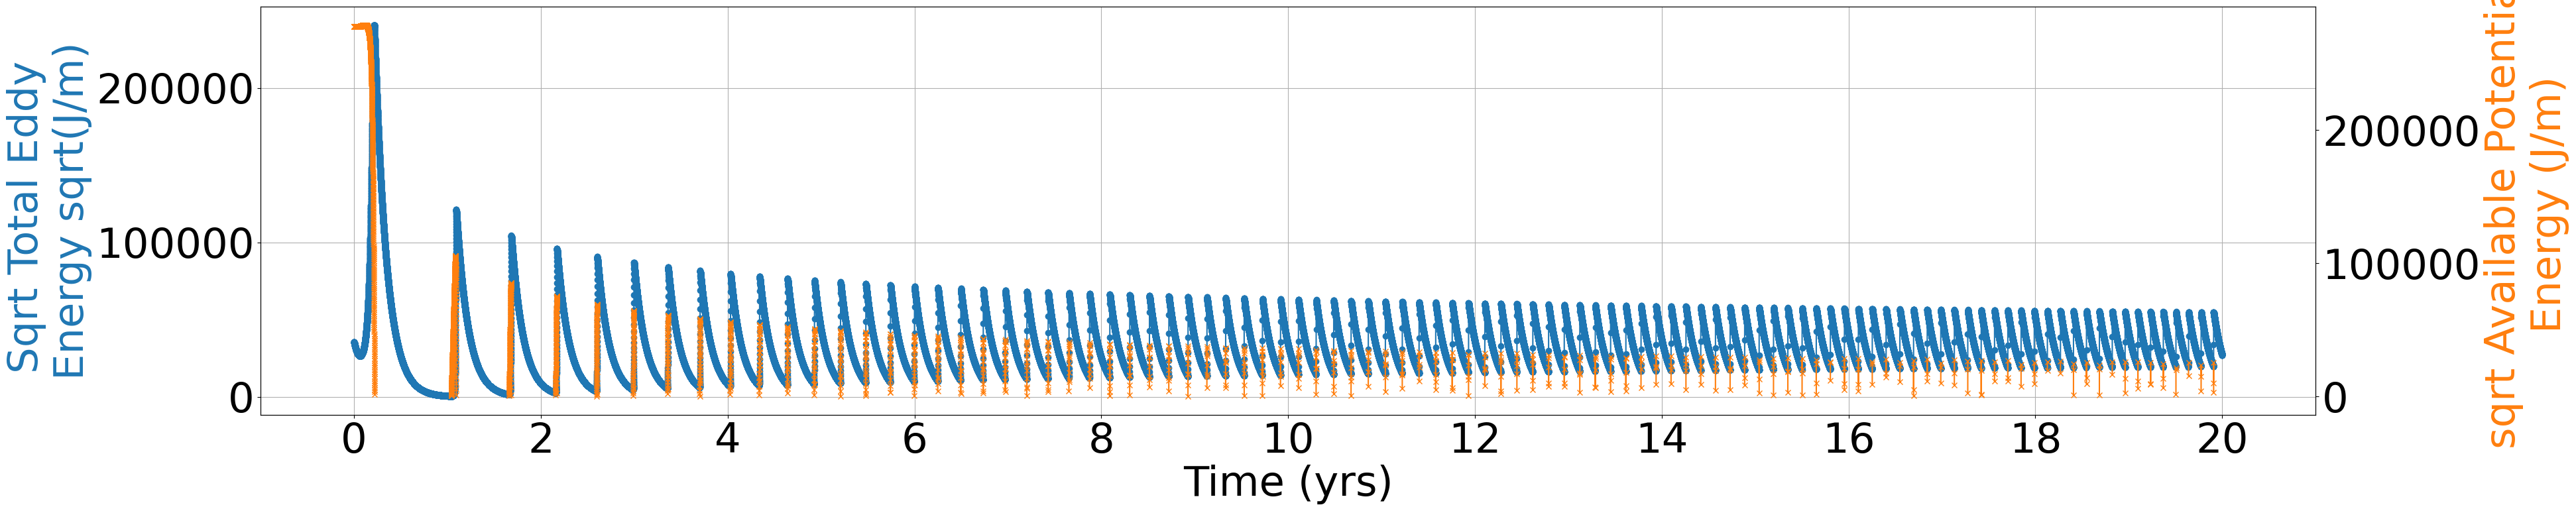

In [121]:
result_odeint = odeint(energies, E0, t, p ,atol=atol, rtol=100*atol)
plt.figure(figsize = (40,8))
ax1 = plt.subplot()

ax1.plot(t/cdrag/(365*60*60*24), np.sqrt(result_odeint[:,0]*Me*b/(alpha*a)), marker = 'o', label = 'E',color = 'C0')
#ax1.set_ylim([0,3.5e9])
ax1.set_ylabel('Sqrt Total Eddy \nEnergy sqrt(J/m)', color = 'C0')
#ax1.set_yticks(np.arange(0.3e9,.55e9,1e8))

ax2 = ax1.twinx()
ax2.plot(t/cdrag/(365*60*60*24),  np.sqrt(result_odeint[:,1]*(cdrag/(alpha*a))**2 *M ), marker = 'x', label = 'APE', color = 'C1')
ax2.set_ylabel('sqrt Available Potential\n Energy (J/m)', color = 'C1')
#ax2.set_ylim([0,3.5e9])
#ax2.set_yticks(np.arange(1.4e9,1.8e9,1e8))
plt.xticks(np.arange(0,22,2))
ax1.set_xlabel('Time (yrs)')

ax1.grid(which = 'both')
## I still don't fully understand why t does not need to be dimensionalised



In [122]:
atol = 1e-11
E0 = [1.05,2] #[E,APE]
cdrag = 5e-7 # 4e-7 has correct drag
M = 1# for p and dt
Me = 1 # for \epsilon

t = np.linspace(0,20*365*24*60*60*cdrag,120000) #*365*24*60*60*cdrag/int(np.sqrt(M))
p = (a, b, cdrag)
def energies(state,t, a,b,cdrag):
    E, APE =  state 
    dE =   np.sqrt(max(atol, APE)) * E - E  * np.sqrt(M)
    dAPE = b * np.sqrt(max(atol, APE))*a /cdrag**2 -   Me* a * b * E *np.sqrt(max(atol, APE))  /cdrag**2
    return [dE, dAPE]

In [123]:
"{:e}".format(np.mean((cdrag/a)**2)) #equilibrium APE

'6.166800e+09'

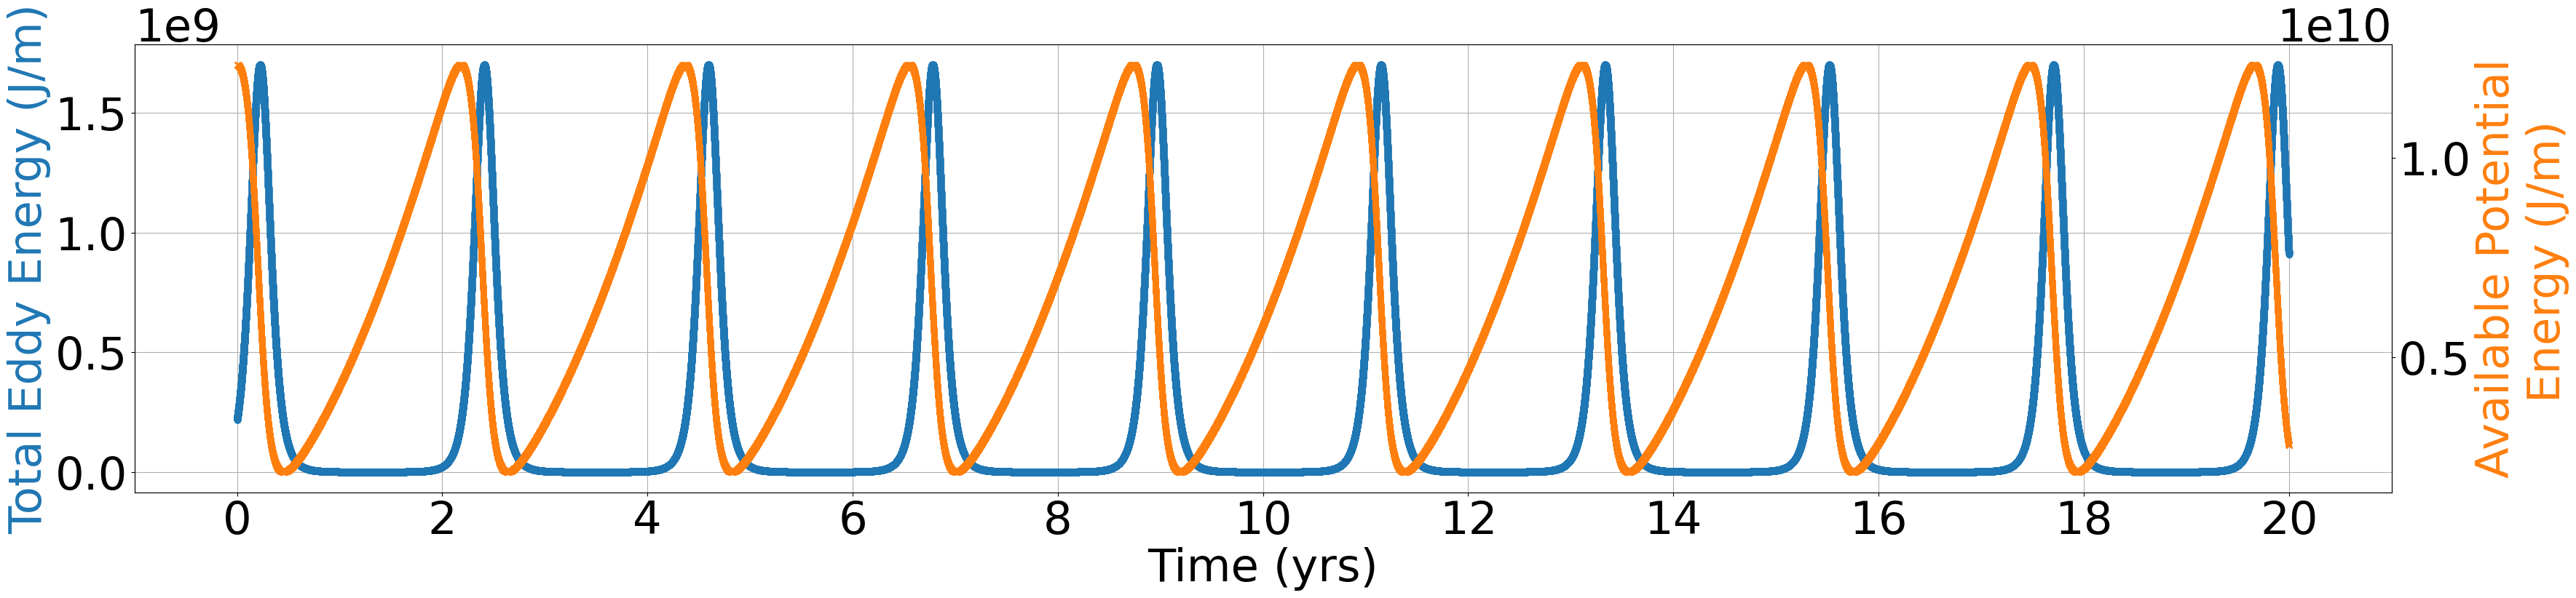

In [132]:
result_odeint = odeint(energies, E0, t, p ,atol=atol, rtol=100*atol)
plt.figure(figsize = (40,8))
ax1 = plt.subplot()

ax1.plot(t/cdrag/(365*60*60*24), result_odeint[:,0]*Me*b/a, marker = 'o', label = 'E',color = 'C0')
#ax1.set_ylim([0,3.5e9])
ax1.set_ylabel('Total Eddy Energy (J/m)', color = 'C0')
#ax1.set_yticks(np.arange(0.3e9,.55e9,1e8))

ax2 = ax1.twinx()
ax2.plot(t/cdrag/(365*60*60*24), result_odeint[:,1]*(cdrag/a)**2 *M , marker = 'x', label = 'APE', color = 'C1')
ax2.set_ylabel('Available Potential\n Energy (J/m)', color = 'C1')
#ax2.set_ylim([0,3.5e9])
#ax2.set_yticks(np.arange(1.4e9,1.8e9,1e8))
plt.xticks(np.arange(0,22,2))
ax1.set_xlabel('Time (yrs)')

ax1.grid(which = 'both')
## I still don't fully understand why t does not need to be dimensionalised

In [27]:
atol = 1e-11
E0 = [1.05,2] #[E,APE]
cdrag = 5e-7 # 4e-7 has correct drag
M = 1# for p and dt
Me = 1 # for \epsilon

t = np.linspace(0,20*365*24*60*60*cdrag,120000) #*365*24*60*60*cdrag/int(np.sqrt(M))
p = (a, b, cdrag)
def energies(state,t, a,b,cdrag):
    E, APE =  state 
    dE =   np.sqrt(max(atol, APE)) * E - E  * np.sqrt(M)
    dAPE = b * np.sqrt(max(atol, APE))*a /cdrag**2 -   Me* a * b * E *np.sqrt(max(atol, APE))  /cdrag**2
    return [dE, dAPE]

In [28]:
"{:e}".format(np.mean((cdrag/a)**2)) #equilibrium APE

'1.541700e+09'

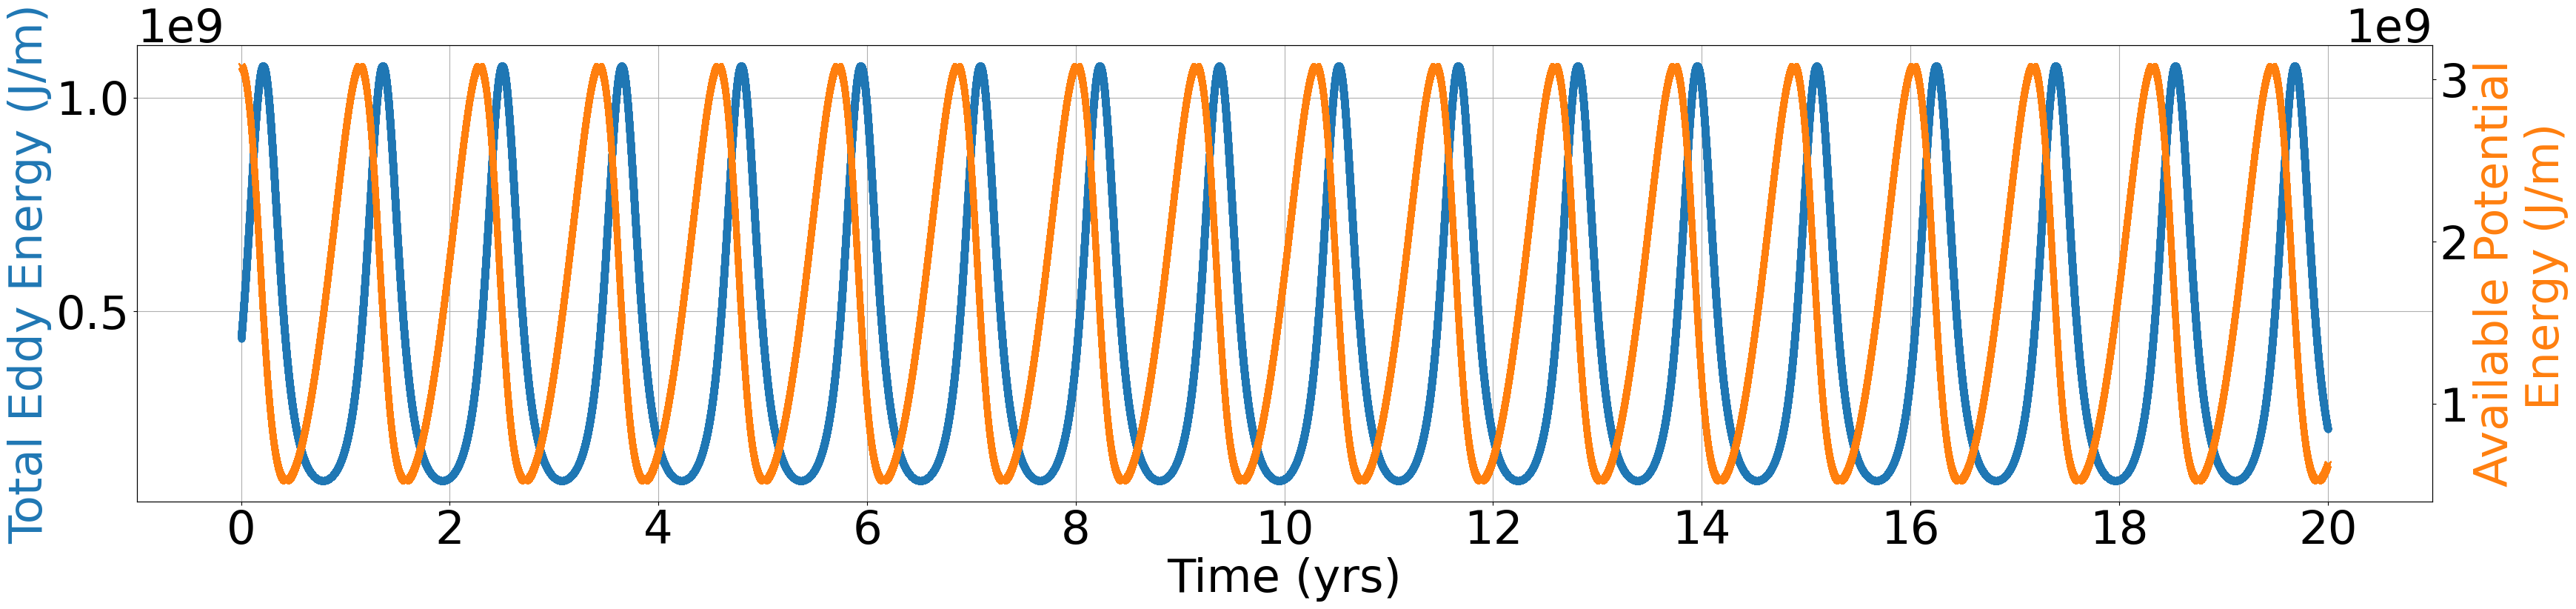

In [29]:
result_odeint = odeint(energies, E0, t, p ,atol=atol, rtol=100*atol)
plt.figure(figsize = (40,8))
ax1 = plt.subplot()

ax1.plot(t/cdrag/(365*60*60*24), result_odeint[:,0]*Me*b/a, marker = 'o', label = 'E',color = 'C0')
#ax1.set_ylim([0,3.5e9])
ax1.set_ylabel('Total Eddy Energy (J/m)', color = 'C0')
#ax1.set_yticks(np.arange(0.3e9,.55e9,1e8))

ax2 = ax1.twinx()
ax2.plot(t/cdrag/(365*60*60*24), result_odeint[:,1]*(cdrag/a)**2 *M , marker = 'x', label = 'APE', color = 'C1')
ax2.set_ylabel('Available Potential\n Energy (J/m)', color = 'C1')
#ax2.set_ylim([0,3.5e9])
#ax2.set_yticks(np.arange(1.4e9,1.8e9,1e8))
plt.xticks(np.arange(0,22,2))
ax1.set_xlabel('Time (yrs)')

ax1.grid(which = 'both')
## I still don't fully understand why t does not need to be dimensionalised

In [14]:
EKE_time = xr.open_mfdataset('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02.nc')
EAPE_time = xr.open_mfdataset('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_EAPE_cdwonly_relsponging.nc')
EAPE_time_TEST = xr.open_mfdataset('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_EAPE_cdwonly_relspongingTEST.nc')

MAPE_time = xr.open_mfdataset('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_MAPE.nc')
APE_cdw_time2 = xr.open_mfdataset('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_APE_corrected_top.nc')## earlier incorrect indexing means corrected top is the cdw layer
APE_cdw_time = xr.open_mfdataset('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_APE_cdwonly_relsponging.nc')

In [219]:
## get average E0 equilibrium
E_mean = np.mean(EKE_time.__xarray_dataarray_variable__.values + EAPE_time_TEST.e.values)
E_mean /1e9

1.695638144

In [220]:
APE_mean = np.mean(APE_cdw_time.e.values)
APE_mean/1e9

3.4147392

In [224]:
(EKE_time.__xarray_dataarray_variable__.isel(Time = 0).values + EAPE_time_TEST.e.isel(Time = 0).values )/ E_mean

1.2826015

In [223]:
APE_cdw_time.e.isel(Time = 0).values / APE_mean

1.3861245

In [235]:
max(EKE_time.__xarray_dataarray_variable__.values + EAPE_time_TEST.e.values )/ E_mean #checking the maximum equilibrium value for APE

3.0525577

In [230]:
max(APE_cdw_time.e.values) / APE_mean #checking the maximum equilibrium value for APE

2.0442097

Text(0.5, 1.0, 'Energy diagnostics from MOM6 ASC experiments')

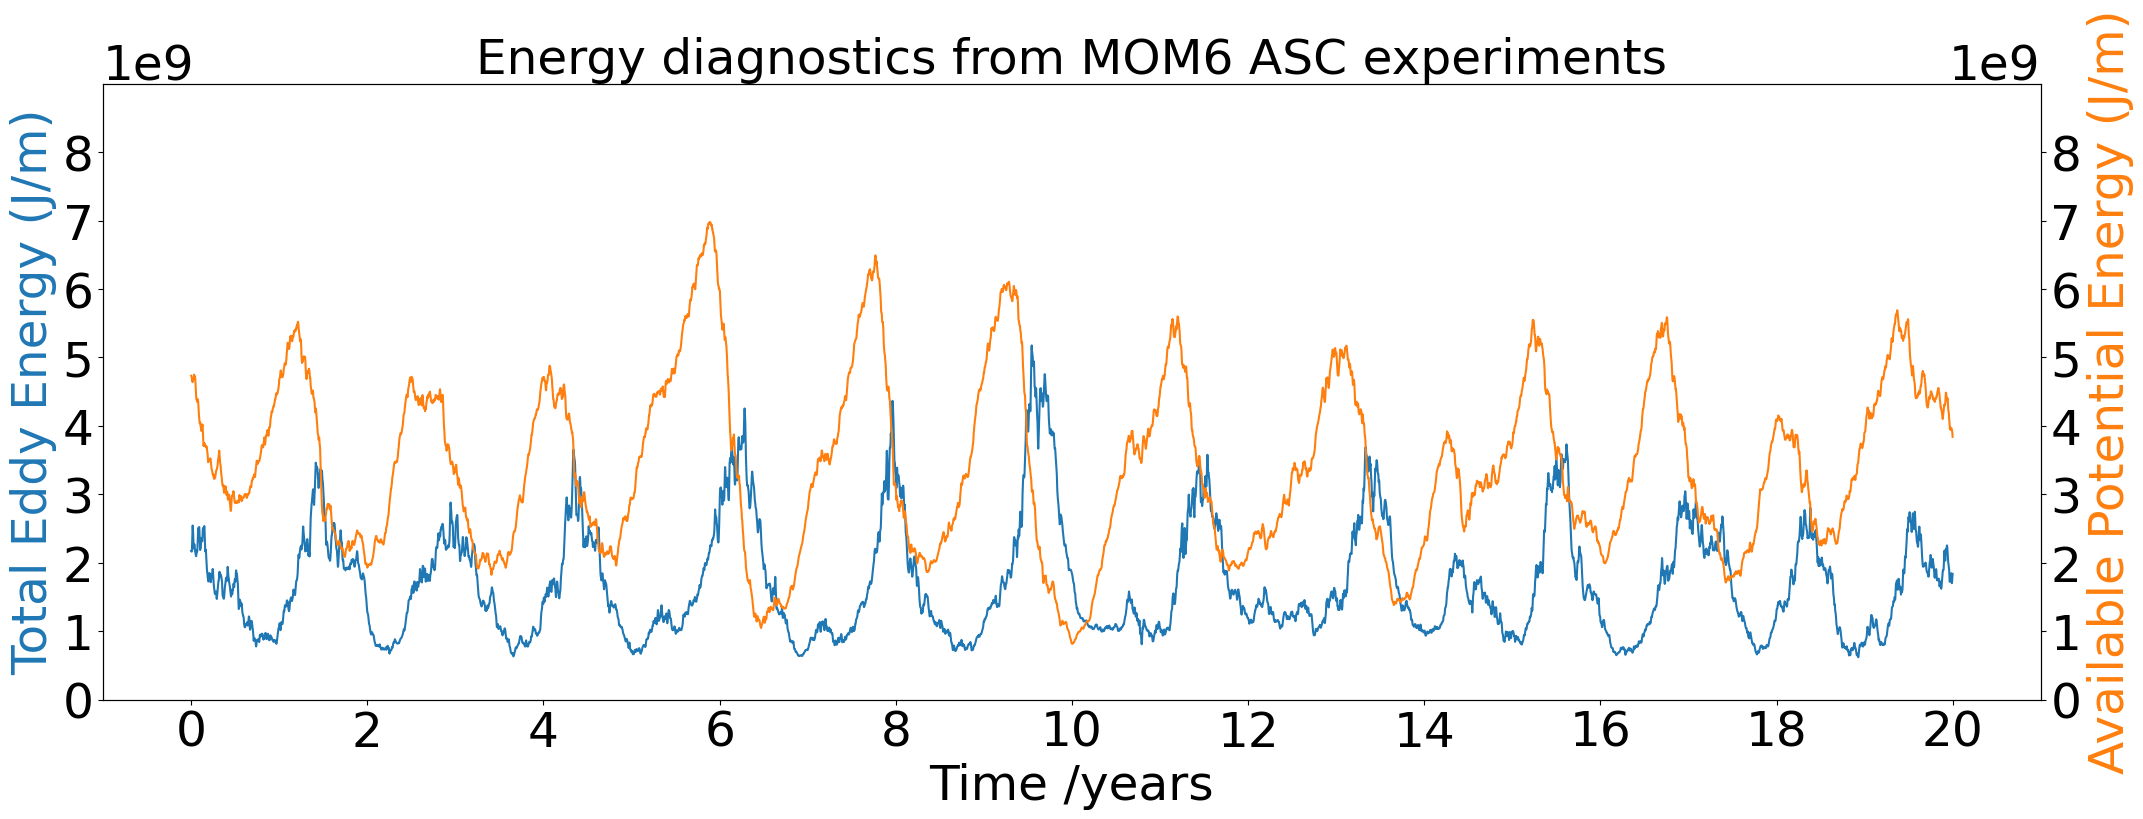

In [27]:
plt.figure(figsize = (25,8))
ax1 = plt.subplot()

ax1.plot((EKE_time.coords['Time'].values-51),EKE_time.__xarray_dataarray_variable__.values + EAPE_time_TEST.e.values, color = 'C0')
ax1.set_ylim([0,9e9])
ax1.set_ylabel('Total Eddy Energy (J/m)', color = 'C0')
ax1.set_yticks(np.arange(0,9e9,1e9))#9e9

ax2 = ax1.twinx()
ax2.plot((EKE_time.coords['Time'].values-51),APE_cdw_time.e.values, color = 'C1')
ax2.set_ylabel('Available Potential Energy (J/m)', color = 'C1')
ax2.set_ylim([0,9e9])
ax2.set_yticks(np.arange(0,9e9,1e9))
plt.xticks(np.arange(0,22,2))
ax1.set_xlabel('Time /years')
plt.title('Energy diagnostics from MOM6 ASC experiments')

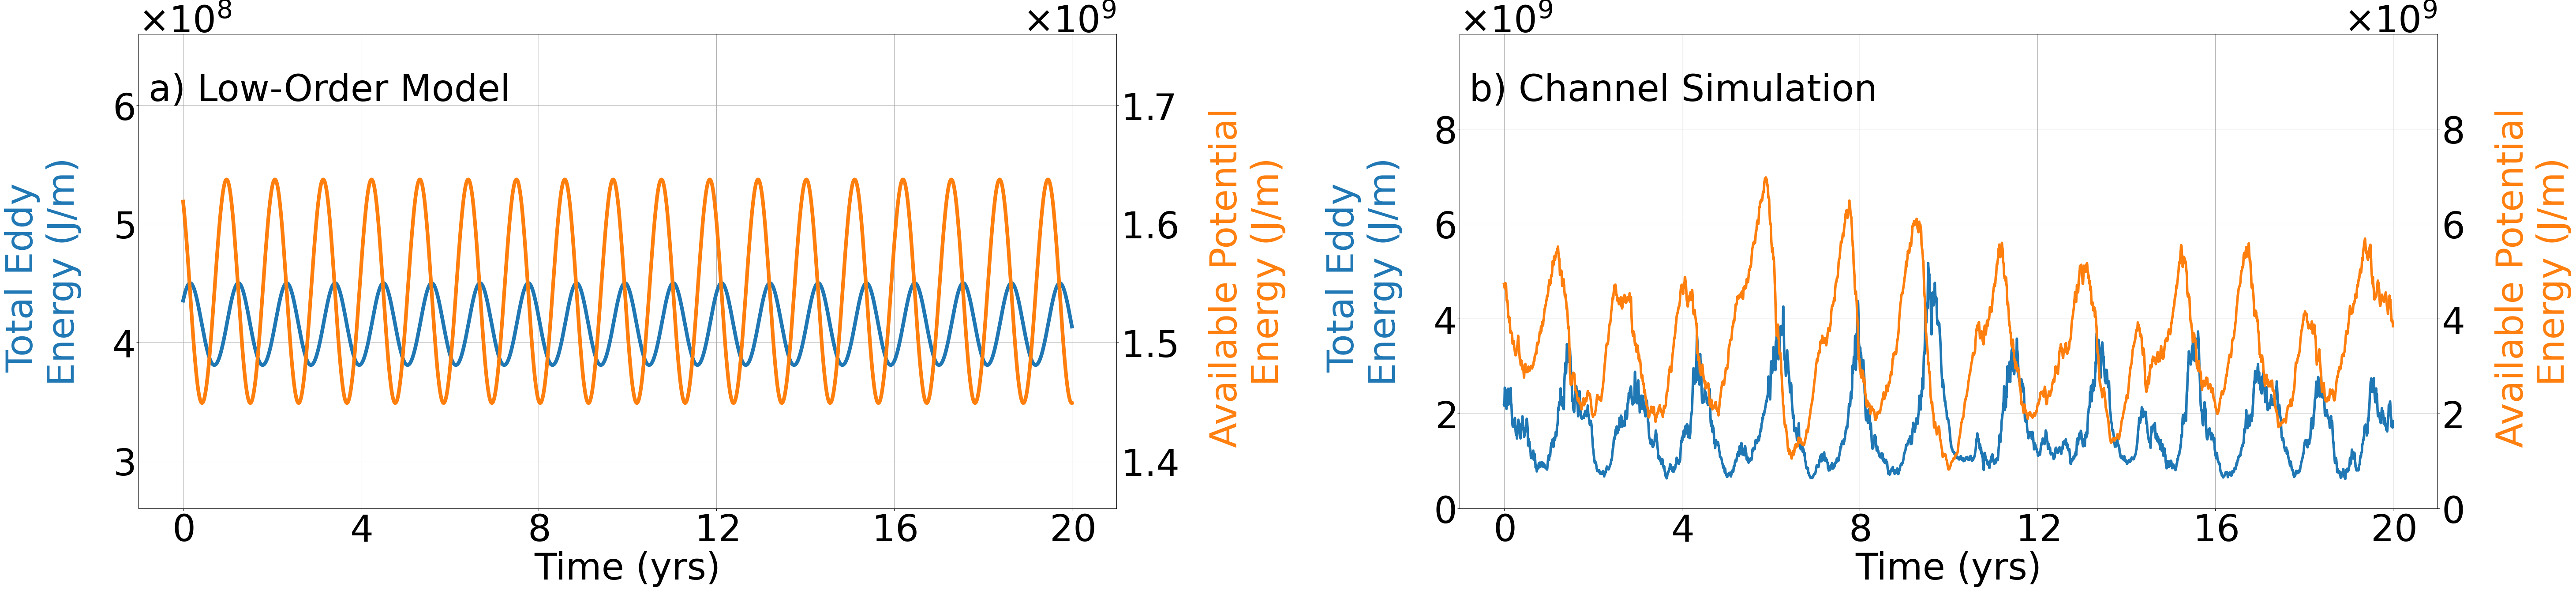

In [73]:
fig, axs = plt.subplots( 1,2 , figsize = (60,15)) #(30,25, vertical)
lineweight = 4
lineweight_ODE = 6
axs[0].plot(t/cdrag/(365*60*60*24), result_odeint[:,0]*b/a, lw = lineweight_ODE , label = 'E',color = 'C0')
axs[0].set_ylim([0.26e9,0.66e9])
axs[0].set_ylabel('Total Eddy \nEnergy (J/m)', color = 'C0', labelpad = 50)
axs[0].set_yticks(np.arange(0.3e9,.65e9,1e8))

ax2 = axs[0].twinx()
ax2.plot(t/cdrag/(365*60*60*24), result_odeint[:,1]*(cdrag/a)**2 , lw = lineweight_ODE, label = 'APE', color = 'C1')
ax2.set_ylabel('Available Potential \nEnergy (J/m)', color = 'C1', labelpad = 50)
ax2.set_ylim([1.36e9,1.76e9])
ax2.set_yticks(np.arange(1.4e9,1.8e9,1e8))
axs[0].set_xticks(np.arange(0,22,4))
axs[0].set_xlabel('Time (yrs)')
axs[0].grid(which = 'both')
axs[0].ticklabel_format(useMathText=True)
axs[0].annotate('a) Low-Order Model', xy = (0.01,0.86), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction')
ax2.ticklabel_format(useMathText=True)

axs[1].plot((EKE_time.coords['Time'].values-51),EKE_time.__xarray_dataarray_variable__.values + EAPE_time_TEST.e.values,  lw = lineweight ,color = 'C0')
axs[1].set_ylim([0,10e9])
axs[1].set_ylabel('Total Eddy \nEnergy (J/m)', color = 'C0', labelpad = 50)
axs[1].set_yticks(np.arange(0,10e9,2e9))#9e9

ax3 = axs[1].twinx()
ax3.plot((EKE_time.coords['Time'].values-51),APE_cdw_time.e.values,  lw = lineweight , color = 'C1')
ax3.set_ylabel('Available Potential \nEnergy (J/m)', color = 'C1', labelpad = 50)
ax3.set_ylim([0,10e9])
ax3.set_yticks(np.arange(0,10e9,2e9))
axs[1].set_xticks(np.arange(0,22,4))
axs[1].set_xlabel('Time (yrs)')
axs[1].grid(which = 'both')
axs[1].ticklabel_format(useMathText=True)
ax3.ticklabel_format(useMathText=True)

axs[1].annotate('b) Channel Simulation', xy = (0.01,0.86), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction')

#fig.subplots_adjust(wspace=0.6)

plt.tight_layout()
plt.savefig('/g/data/v45/qo9901/layeredASFpaper_fig/Fig7_low-order-model-compare.pdf')

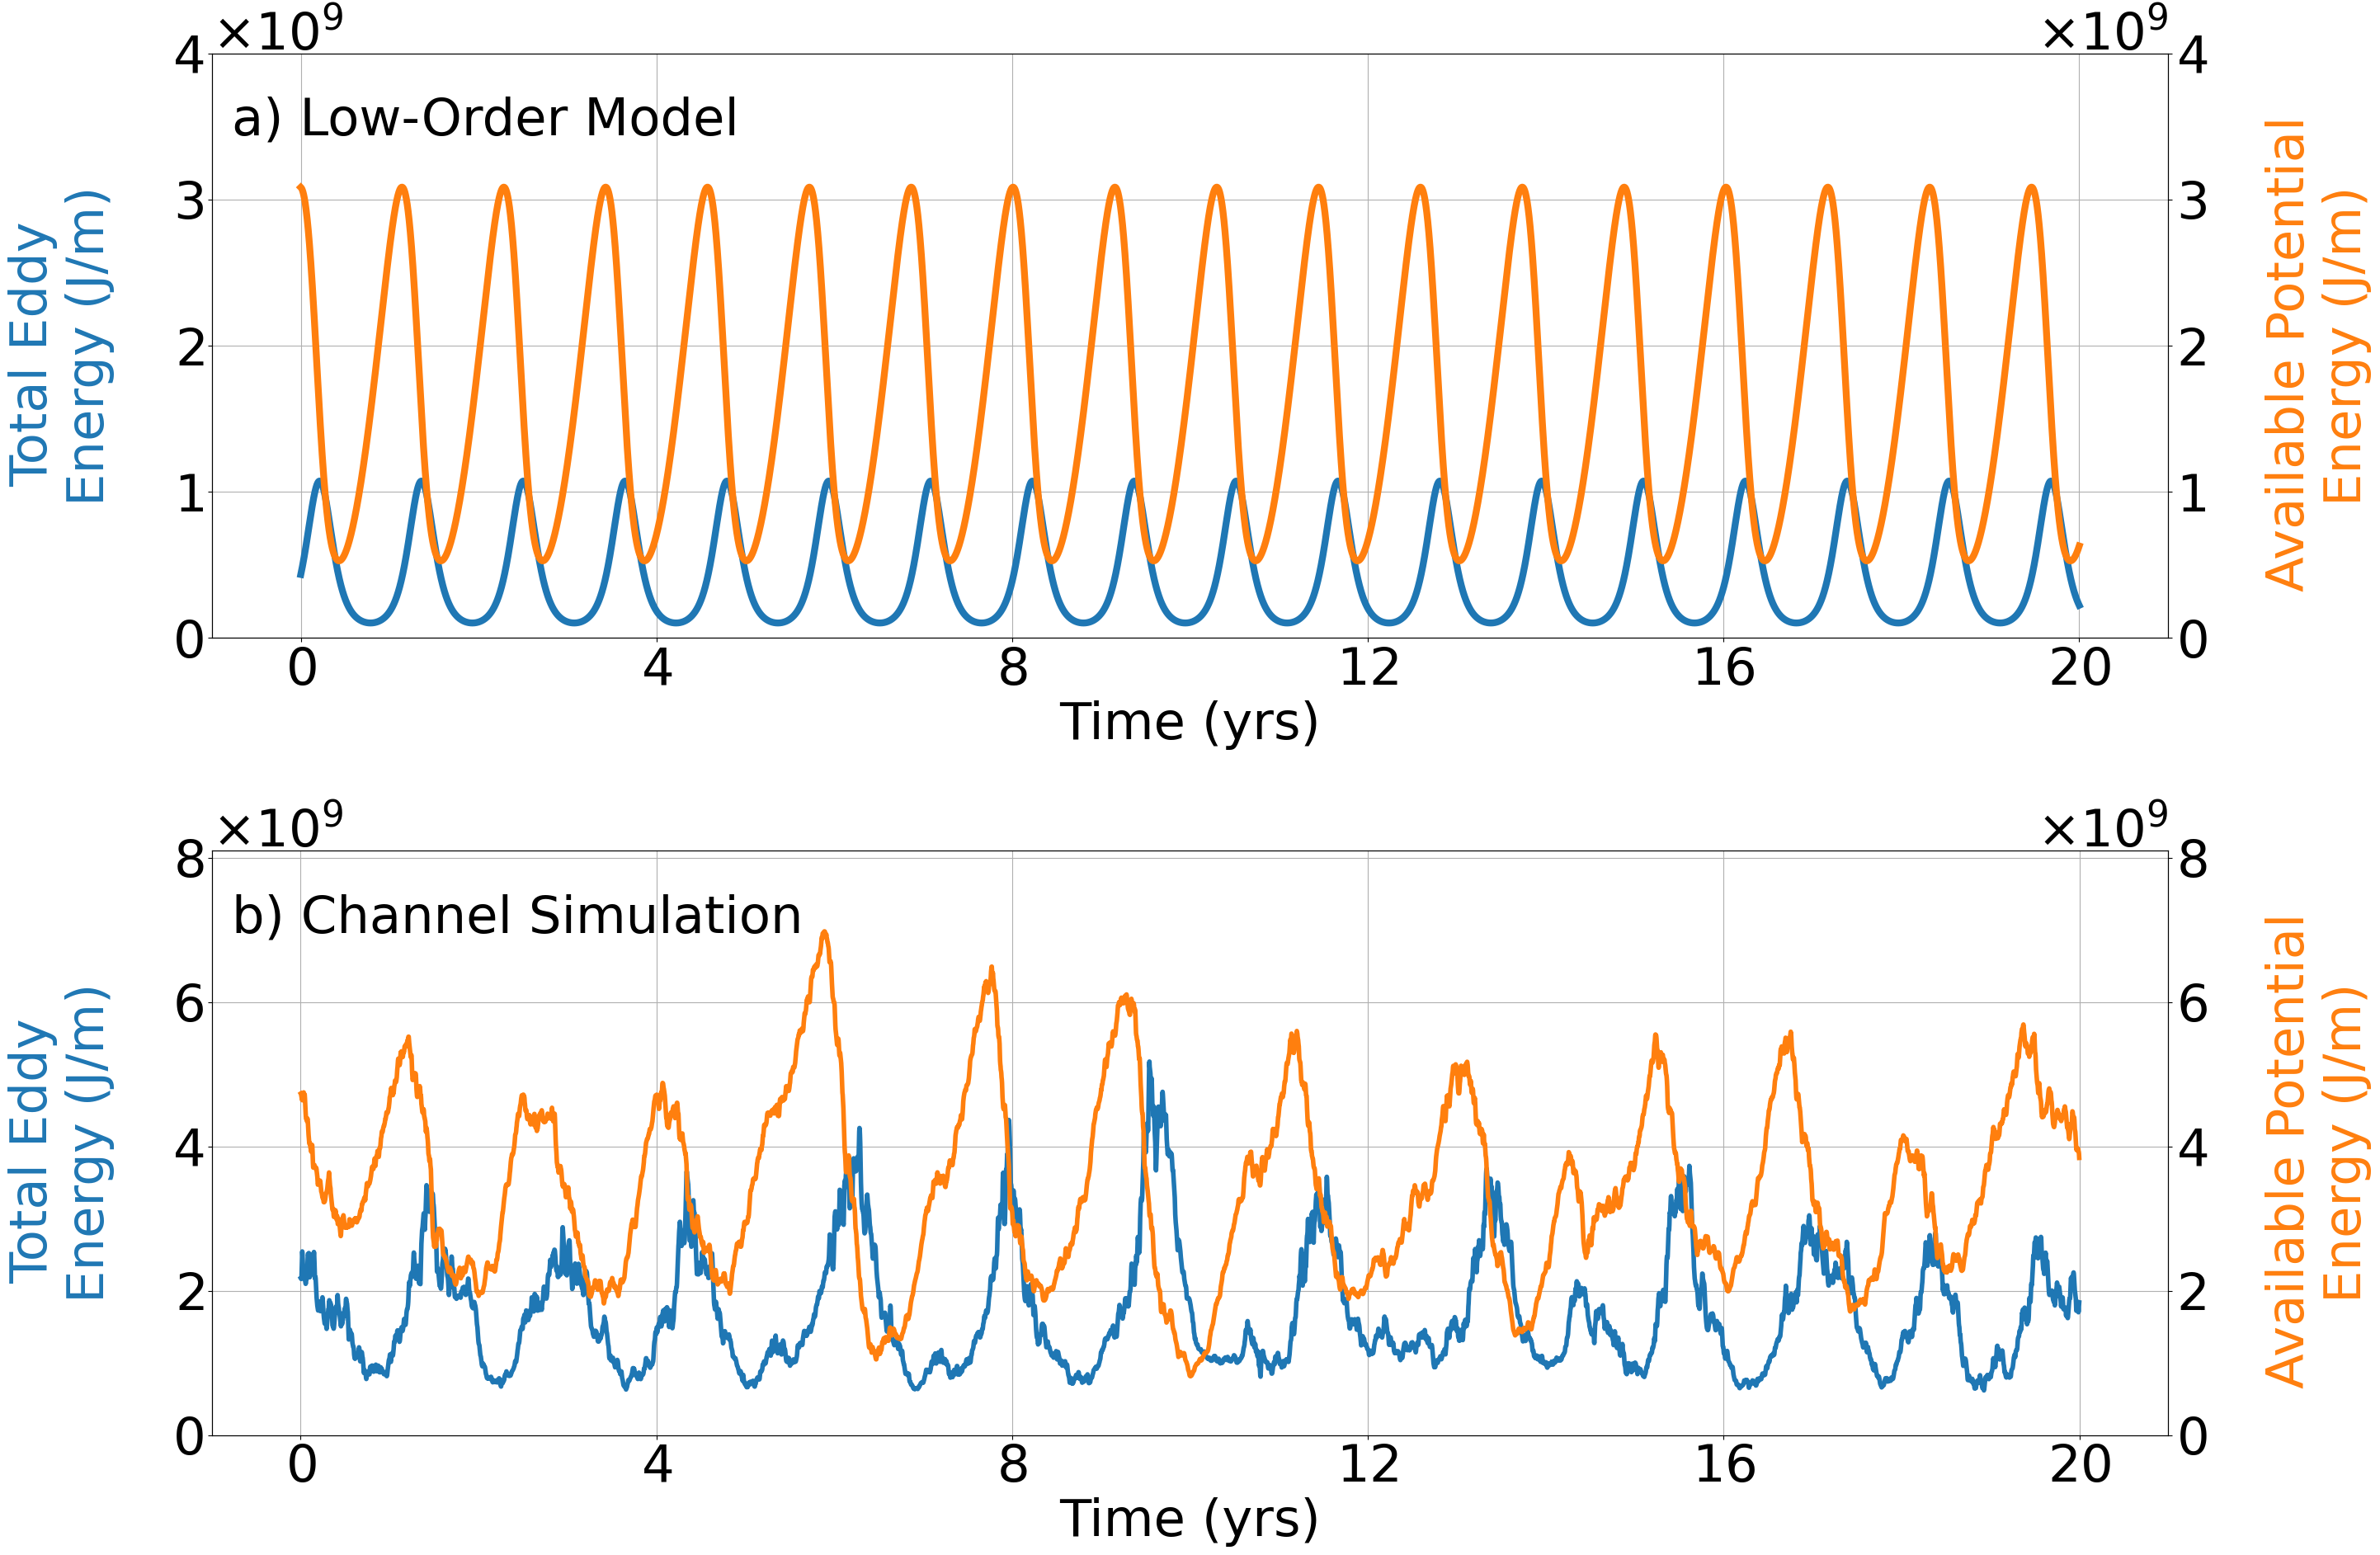

In [20]:
## Final plot, using E0  = [1.05,2]

fig, axs = plt.subplots( 2,1 , figsize = (30,20)) #(30,25, vertical)
lineweight = 4
lineweight_ODE = 6
axs[0].plot(t/cdrag/(365*60*60*24), result_odeint[:,0]*b/a, lw = lineweight_ODE , label = 'E',color = 'C0')
axs[0].set_ylim([0,4e9])
axs[0].set_ylabel('Total Eddy \nEnergy (J/m)', color = 'C0', labelpad = 50)
#axs[0].set_yticks(np.arange(0.3e9,.61e9,1e8))

ax2 = axs[0].twinx()
ax2.plot(t/cdrag/(365*60*60*24), result_odeint[:,1]*(cdrag/a)**2 , lw = lineweight_ODE, label = 'APE', color = 'C1')
ax2.set_ylabel('Available Potential \nEnergy (J/m)', color = 'C1', labelpad = 50)
ax2.set_ylim([0,4e9])
axs[0].set_xticks(np.arange(0,22,4))
axs[0].set_xlabel('Time (yrs)')
axs[0].grid(which = 'both')
axs[0].ticklabel_format(useMathText=True)
axs[0].annotate('a) Low-Order Model', xy = (0.01,0.86), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction')
ax2.ticklabel_format(useMathText=True)

axs[1].plot((EKE_time.coords['Time'].values-51),EKE_time.__xarray_dataarray_variable__.values + EAPE_time_TEST.e.values,  lw = lineweight ,color = 'C0')
axs[1].set_ylim([0,8.1e9])
axs[1].set_ylabel('Total Eddy \nEnergy (J/m)', color = 'C0', labelpad = 50)
axs[1].set_yticks(np.arange(0,8.1e9,2e9))#9e9

ax3 = axs[1].twinx()
ax3.plot((EKE_time.coords['Time'].values-51),APE_cdw_time.e.values,  lw = lineweight , color = 'C1')
ax3.set_ylabel('Available Potential \nEnergy (J/m)', color = 'C1', labelpad = 50)
ax3.set_ylim([0,8.1e9])
ax3.set_yticks(np.arange(0,8.1e9,2e9))
axs[1].set_xticks(np.arange(0,22,4))
axs[1].set_xlabel('Time (yrs)')
axs[1].grid(which = 'both')
axs[1].ticklabel_format(useMathText=True)
ax3.ticklabel_format(useMathText=True)

axs[1].annotate('b) Channel Simulation', xy = (0.01,0.86), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction')

#fig.subplots_adjust(wspace=0.6)

plt.tight_layout()
plt.savefig('/g/data/v45/qo9901/layeredASFpaper_fig/Figreview_low-order-model-compare-fullwidth.pdf')

In [14]:
"{:e}".format(np.mean(result_odeint[:,1]*(cdrag/a)**2)) # scaled solution

'1.541914e+09'

In [ ]:
## saving all equilibrium values for cdrag and tau experiments

In [ ]:
#equilibrium E

In [275]:
"{:e}".format(b/a* Me) #cdrag =1.5e-8

'4.144923e+08'

In [281]:
"{:e}".format(b/a* Me) #cdrag =2.4e-8

'4.144923e+08'

In [284]:
"{:e}".format(b/a* Me) #cdrag =3.6e-8

'4.144923e+08'

In [287]:
"{:e}".format(b/a* Me) #cdrag =4.5e-8

'4.144923e+08'

In [227]:
"{:e}".format(b/a* Me) #tau =0.025

'1.036231e+08'

In [238]:
"{:e}".format(b/a* Me) #tau =0.05

'2.072461e+08'

In [249]:
"{:e}".format(b/a* Me) #tau =0.075

'3.108692e+08'

In [272]:
"{:e}".format(b/a* Me) #tau =0.1

'4.144923e+08'

In [261]:
"{:e}".format(b/a* Me) #tau =0.125

'5.181154e+08'